In [204]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Set figure size
sns.set(rc={'figure.figsize':(16,10)})

#Load data
df = pd.read_csv(os.path.join('data','data_filtered.csv'))
df2  = pd.read_csv(os.path.join('data','data_all.csv'))

#Enable CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df

,sd,Q25,IQR,sp.ent,sfm,meanfun,mindom,dfrange,label
0,0.241585,0.455971,-0.601712,0.796058,0.925288,1.302489,-0.708404,-0.415794,1
1,-0.114476,-0.105393,0.401743,0.461699,-0.229014,-0.259737,-0.461523,0.412186,0
2,-1.284107,1.726540,-1.169425,-1.599113,-1.269425,1.315527,-0.461523,1.777355,1
3,1.089943,-0.391539,0.786946,0.578250,0.982092,-0.698228,-0.708404,-0.679948,0
4,0.231523,0.681061,-0.527833,0.508050,0.516462,1.167348,-0.708404,-1.343664,1
...,...,...,...,...,...,...,...,...,...
3163,1.087355,-0.480803,0.982768,1.385949,1.667369,-0.969765,-0.338082,-1.208257,0
3164,-1.471392,0.863030,-1.176833,-0.555301,-1.128432,0.530223,1.143207,-1.214917,1
3165,0.644400,-0.395149,0.953317,0.626947,0.305185,-0.983770,-0.708404,-0.688828,0
3166,1.557415,-0.558784,0.970942,1.076622,1.232644,-0.441604,-0.708404,-0.005133,0


In [205]:
feature_size = len(df.drop(['label'],axis=1).columns)
print(f'Number of Features: {feature_size}')



train_x, test_x, train_y, test_y = train_test_split(
    df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=42)


train_x = torch.tensor(train_x.values,
                      dtype=torch.float32, device=device)
train_y = torch.tensor(train_y.to_frame().values,
                      dtype=torch.float32, device=device)

test_x = torch.tensor(test_x.values,
                      dtype=torch.float32, device=device)
test_y = torch.tensor(test_y.to_frame().values,
                      dtype=torch.float32, device=device)

# train_x = torch.tensor(
#     [[0, 0], [0, 1], [1, 0], [1, 1]],
#     dtype=torch.float32, device=device)

# train_y
# train_y = torch.tensor(
#     [[0], [1], [1], [0]],
#     dtype=torch.float32, device=device)

# test_x = torch.tensor(
#     [[1, 1]],
#     dtype=torch.float32, device=device)

# test_y = torch.tensor(
#     [[0]],
#     dtype=torch.float32, device=device)

Number of Features: 8


In [ ]:
#         self.l1 = torch.nn.Linear(input_size, hidden_size, device=device)
#         self.relu = torch.nn.ReLU()
#         self.l2 = torch.nn.Linear(hidden_size, num_classes, device=device)

Linear(in_features=8, out_features=16, bias=True)


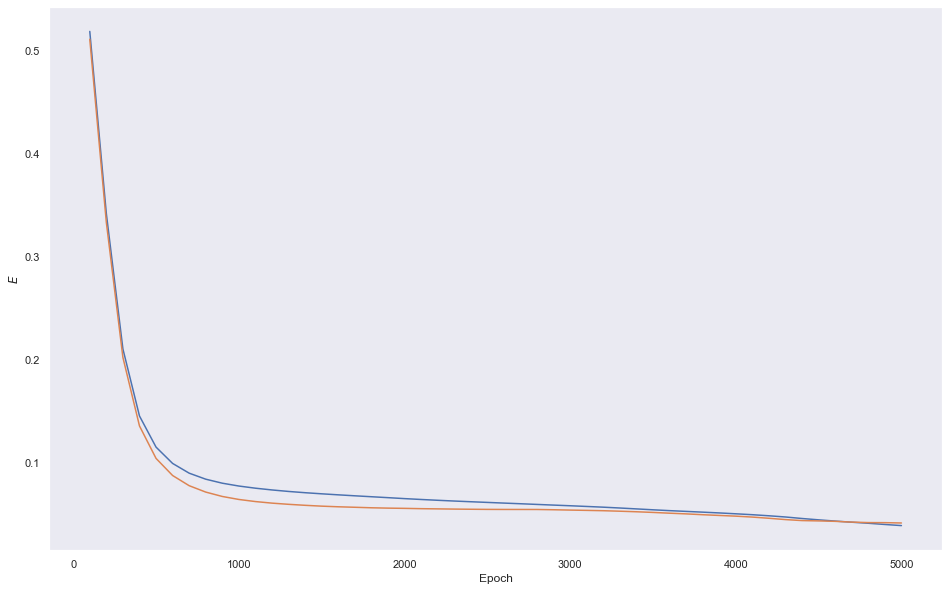

In [211]:
class Model(torch.nn.Module):
    def __init__(self,
                 input_size: int,  # Number of features
                 num_classes: int, # Number of classes
                 hidden: int,      # Number of hidden layers
                 hidden_size: list,# Sizes of the hidden layers in sequential order
                 ):
        super().__init__()

        assert(hidden == len(hidden_size) and hidden > 0)

        # Activation function
        self.activate = torch.nn.ReLU()

        # Input Layer
        _layers = [torch.nn.Linear(
            input_size, hidden_size[0], device=device)]

        # For every hidden layer pair
        for i in range(1, hidden-1):
            _layers.append(
                torch.nn.Linear(hidden_size[i-1],
                                hidden_size[i], device=device))

        # Output layer
        _layers.append(torch.nn.Linear(hidden_size[hidden-1],
                                       num_classes, device=device))

        # Convert to Parameter list, to be accessible by optimiser
        self.layers = torch.nn.ParameterList(_layers)
        print(self.layers[0])
    def forward(self, x):
        out = self.layers[0](x)
    
        for layer in self.layers[1:]:
            out = self.activate(out)
            out = layer(out)
        

#         out = self.l1(x)
#         out = self.relu(out)
#         out = self.l2(out)

        return out  # Return logits

    def train(self, train_x, train_y,
              epochs, interval=100):

        # Initalise optimiser

        # optimiser = torch.optim.SGD(model.parameters(),lr=0.1)
        optimiser = torch.optim.Adam(model.parameters())

        history = []  # Save error loss over time

        # Training loop
        for step in range(1, epochs+1):

            # Train
            optimiser.zero_grad()
            output = self(train_x)
            error = torch.nn.functional.binary_cross_entropy_with_logits(
                output, train_y)
            error.backward()
            optimiser.step()

            # Print to standard output
            if interval > 0 and step % interval == 0:
                print(step, error.detach().tolist())
                history.append((step, error.tolist()))

        return pd.DataFrame(history, columns=['Epoch', 'Train Loss'])

    def test(self, test_x, test_y):
        error = []
        with torch.no_grad():
            outputs = torch.sigmoid(self(test_x))
            for (x, pred, actual) in zip(test_x, outputs, test_y):
                error.append(
                    torch.nn.functional.binary_cross_entropy(
                        pred, actual)
                )
        return error

    def train_and_test(self, train_x, train_y, test_x, test_y, epochs, interval=1000, trace=False):

        # Initialise optimiser
        optimiser = torch.optim.Adam(model.parameters())

        history = []  # Save error loss over time

        # Training and testing loop
        for step in range(1, epochs+1):

            # Train
            optimiser.zero_grad()
            output = self(train_x)
            error = torch.nn.functional.binary_cross_entropy_with_logits(
                output, train_y)
            error.backward()
            optimiser.step()

            # Calculate test error every interval and save to history
            if interval > 0 and step % interval == 0:
                # Test
                test_error = 0

                with torch.no_grad():
                    outputs = torch.sigmoid(self(test_x))
                    # Calculate average error over test set
                    for (x, pred, actual) in zip(test_x, outputs, test_y):
                        test_error += torch.nn.functional.binary_cross_entropy(
                            pred, actual)

                if trace:
                    print(step, error.detach().tolist())

                history.append(
                    (step, error.tolist(), (test_error/len(test_x)).tolist()))

        return pd.DataFrame(history, columns=['Epoch', 'Train Loss', 'Test Loss'])

# Initialise model


model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[16])
model.to(device)

# Training

history = model.train_and_test(train_x, train_y, test_x, test_y,
                               interval=100, epochs=5000)


(fig, ax) = plt.subplots(1, 1)
sns.lineplot(data=history, x='Epoch', y='Train Loss')
sns.lineplot(data=history, x='Epoch', y='Test Loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('$E$')
# ax.plot(range(1, len(history) + 1), history, linestyle='-', linewidth=3)

ax.grid()

In [212]:
with torch.no_grad():
    
    #Get outputs from model
    outputs = torch.flatten(torch.sigmoid(model(test_x))).tolist()
    
    #Round to nearest integer -> [0,1]
    prediction = list(map(round,outputs))

actual = torch.flatten(test_y).tolist()    

<AxesSubplot:>

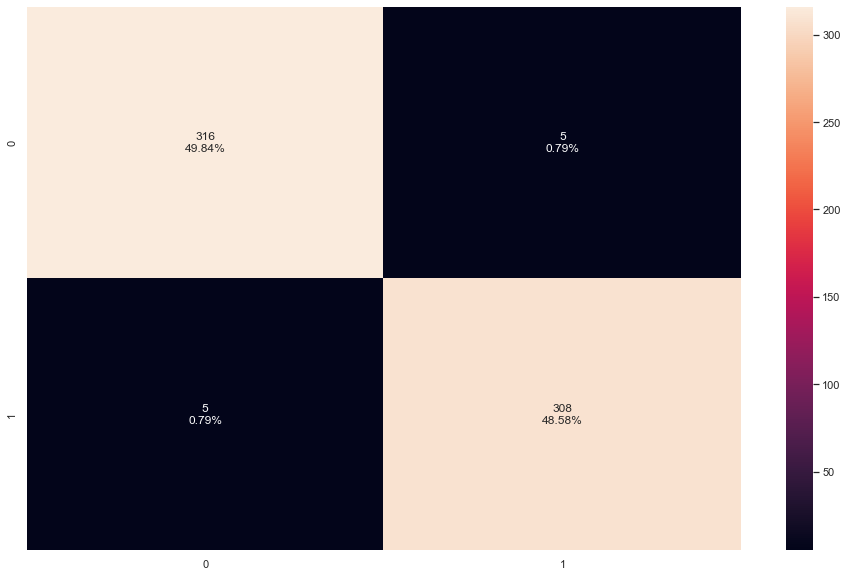

In [213]:
#Generate confusion matrix
cf_matrix = confusion_matrix(actual, prediction)

count      = ["{0:0.0f}".format(v) for v in cf_matrix.flatten()]
percentage = ["{0:.2%}".format(v) for v in cf_matrix.flatten()/np.sum(cf_matrix)]


labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
          zip(count,percentage)]).reshape(2,2)

sns.heatmap(cf_matrix,fmt='',annot=labels)

